# Navenet V3

Disparity Based anomaly detection for navigation

In [1]:
import utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0
cuda:0


### Prepare Data

In [2]:
train_path = "/home/michael/Desktop/BytesDB_train_normal/"
test_normal_path = "/home/michael/Desktop/BytesDB_test_normal/"
test_anormal_path = "/home/michael/Desktop/BytesDB_test_anormal/"

train_data =  utils.BytesDataset(train_path, crop=90)
test_normal_data  =  utils.BytesDataset(test_normal_path, crop=90)
test_anormal_data  =  utils.BytesDataset(test_anormal_path, crop=90)

In [3]:
import random

# returns right mask, right image, left mask, left image, path

def batch_generator(dataset, image_shape=(3,90,320), path_length=30, collision_buffering=35, vertical_crop=90, robot_width=0.6, max_dt=0.45, batch_size=16):
    while True:
        
        # create memory for training data
        left_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        right_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        
        left_masks = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        right_masks = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2])) 
        
        i = 0
        while i < batch_size:
            
            rand_source = random.randint(0, len(dataset.data)-1)
            if dataset.index_exists(rand_source) and dataset.index_exists(rand_source+1):
                target = min(rand_source + path_length, dataset.get_next_break(rand_source)-collision_buffering-1)
                if target - rand_source > 0:
                    try:
                        # make sure no breaks in the data
                        for t in range(rand_source, target):
                            if dataset.data['dt'][t] > max_dt:
                                raise Exception("too large of a skip in data recording")
                        
                        # Add data into batch
                        path = dataset.path_source_to_target(rand_source, target)
                        
                        mask_left = torch.from_numpy(utils.make_mask_from_path(path, robot_width=robot_width, vertical_crop=vertical_crop, image_shape=(image_shape[1], image_shape[2], image_shape[0]))).transpose(0,2).transpose(1,2)
                        mask_right = torch.from_numpy(utils.make_mask_from_path(path, robot_width=robot_width, vertical_crop=vertical_crop, image_shape=(image_shape[1], image_shape[2], image_shape[0]), right=True)).transpose(0,2).transpose(1,2)
                                                
                        left_images[i] = dataset.read_torch_image(rand_source)
                        left_masks[i] = mask_left

                        right_images[i] =  dataset.read_torch_image(rand_source, right=True)
                        right_masks[i] = mask_right

                        i += 1
                    except Exception as e:
                        pass
                        
        yield right_masks, right_images, left_masks, left_images

In [4]:
right_masks, right_images, left_masks, left_images = next(batch_generator(train_data))

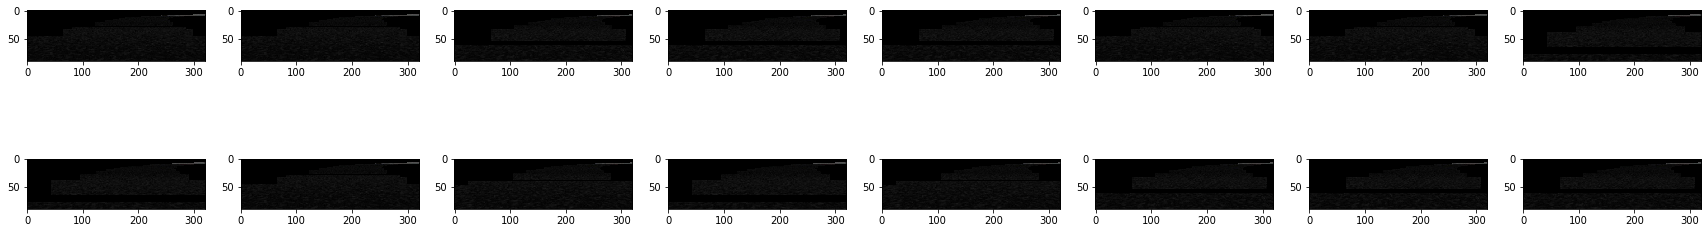

In [5]:
fig = plt.figure(figsize=(30,5))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow(utils.torch_image_to_cv_image(left_images[i]*left_masks[i])*left_masks[i].transpose(0,2).transpose(0,1).numpy())

### Build Model

In [6]:
def same_padding(stride, width, height, filter_size):
    pad_w = ((stride-1)*width-stride+filter_size)/2
    pad_h = ((stride-1)*height-stride+filter_size)/2
    return (int(pad_h),int(pad_w))

class NavNet(nn.Module):
    def __init__(self, input_shape=(3, 90, 320)):
        super(NavNet, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2]//2,input_shape[1]//2,5)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2]//2,input_shape[1]//2,5)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        
        self.decoder = torch.nn.Sequential(
            nn.UpsamplingNearest2d((input_shape[1]//4, input_shape[2]//4)),
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.UpsamplingNearest2d((input_shape[1]//2, input_shape[2]//2)),
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.UpsamplingNearest2d((input_shape[1], input_shape[2])),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            # output has two channels. channel 1 = left disp, channel 2 = right disp
            nn.Conv2d(32, 2, kernel_size=1, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],1)),
            nn.Sigmoid()
        )
    
    def forward(self, left_images):
        embedding = self.encoder(left_images)
        output = self.decoder(embedding)
        return output
    
    # Loss function
    # https://github.com/OniroAI/MonoDepth-PyTorch/blob/master/loss.py
    
    def SSIM(self, x, y):
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        mu_x = nn.AvgPool2d(3, 1)(x)
        mu_y = nn.AvgPool2d(3, 1)(y)
        mu_x_mu_y = mu_x * mu_y
        mu_x_sq = mu_x.pow(2)
        mu_y_sq = mu_y.pow(2)

        sigma_x = nn.AvgPool2d(3, 1)(x * x) - mu_x_sq
        sigma_y = nn.AvgPool2d(3, 1)(y * y) - mu_y_sq
        sigma_xy = nn.AvgPool2d(3, 1)(x * y) - mu_x_mu_y

        SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
        SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
        SSIM = SSIM_n / SSIM_d

        return torch.clamp((1 - SSIM) / 2, 0, 1)
    
    def gradient_x(self, img):
        # Pad input to keep output size consistent
        img = F.pad(img, (0, 1, 0, 0), mode="replicate")
        gx = img[:, :, :, :-1] - img[:, :, :, 1:]  # NCHW
        return gx

    def gradient_y(self, img):
        # Pad input to keep output size consistent
        img = F.pad(img, (0, 0, 0, 1), mode="replicate")
        gy = img[:, :, :-1, :] - img[:, :, 1:, :]  # NCHW
        return gy
    
    def disp_smoothness(self, disps, imgs):
        disp_gradients_x = self.gradient_x(disps)
        disp_gradients_y = self.gradient_y(disps)
        
        image_gradients_x = self.gradient_x(imgs)
        image_gradients_y = self.gradient_y(imgs)
        
        weights_x = torch.exp(-torch.mean(torch.abs(image_gradients_x), 1, keepdim=True))
        weights_y = torch.exp(-torch.mean(torch.abs(image_gradients_y), 1, keepdim=True))

        smoothness_x = disp_gradients_x * weights_x
        smoothness_y = disp_gradients_y * weights_y
        
        return torch.abs(smoothness_x) + torch.abs(smoothness_y)
    
    def loss(self, disp, left_images, right_images, alpha=0.85): # large alpha means that SSIM is more important than simple pixelwise L1 loss
        
        # Info about input
        batch_size, _, height, width = left_images.size()
        
        # For applying disparities to images
        x_base = torch.linspace(-1, 1, width).repeat(batch_size, height, 1).type_as(disp) # shape  = Nxheightxwidth
        y_base = torch.linspace(-1, 1, height).repeat(batch_size, width, 1).transpose(1, 2).type_as(disp) 
        
        """Compute loss due to left disparities reconstruction"""
        flow_feild = torch.stack((x_base-disp[:,0,:,:], y_base), dim=3)
        shifted_right_to_left = F.grid_sample(right_images, flow_feild, align_corners=False)
        left_l1_loss =  F.l1_loss(left_images, shifted_right_to_left)
        ssim_left = torch.mean(self.SSIM(left_images, shifted_right_to_left)) 
        loss_rl = alpha*ssim_left+(1-alpha)*left_l1_loss
        
        """Compute loss due to right disparities reconstruction"""
        flow_feild = torch.stack((x_base+disp[:,1,:,:], y_base), dim=3)
        shifted_left_to_right = F.grid_sample(left_images, flow_feild, align_corners=False)
        right_l1_loss =  F.l1_loss(right_images, shifted_left_to_right)
        ssim_right = torch.mean(self.SSIM(right_images, shifted_left_to_right))
        loss_lr = alpha*ssim_right+(1-alpha)*right_l1_loss
        
        """Compute loss due to locally unsmooth regions w/ gradient + edge awareness"""
        disp_left_smoothness = self.disp_smoothness(disp[:,0].unsqueeze(1), left_images)
        disp_right_smoothness = self.disp_smoothness(disp[:,1].unsqueeze(1), right_images)
        
        loss_smoothness_left = F.l1_loss(disp_left_smoothness, torch.zeros(disp_left_smoothness.shape).type_as(disp))
        loss_smoothness_right = F.l1_loss(disp_right_smoothness, torch.zeros(disp_right_smoothness.shape).type_as(disp))
        
        """Compute loss caused by inconsistent disparitiy maps"""
        inconsistency_loss = F.l1_loss(disp[:,0,:,:], disp[:,1,:,:])

        return loss_rl + loss_lr + loss_smoothness_left + loss_smoothness_right + inconsistency_loss

### Train Model

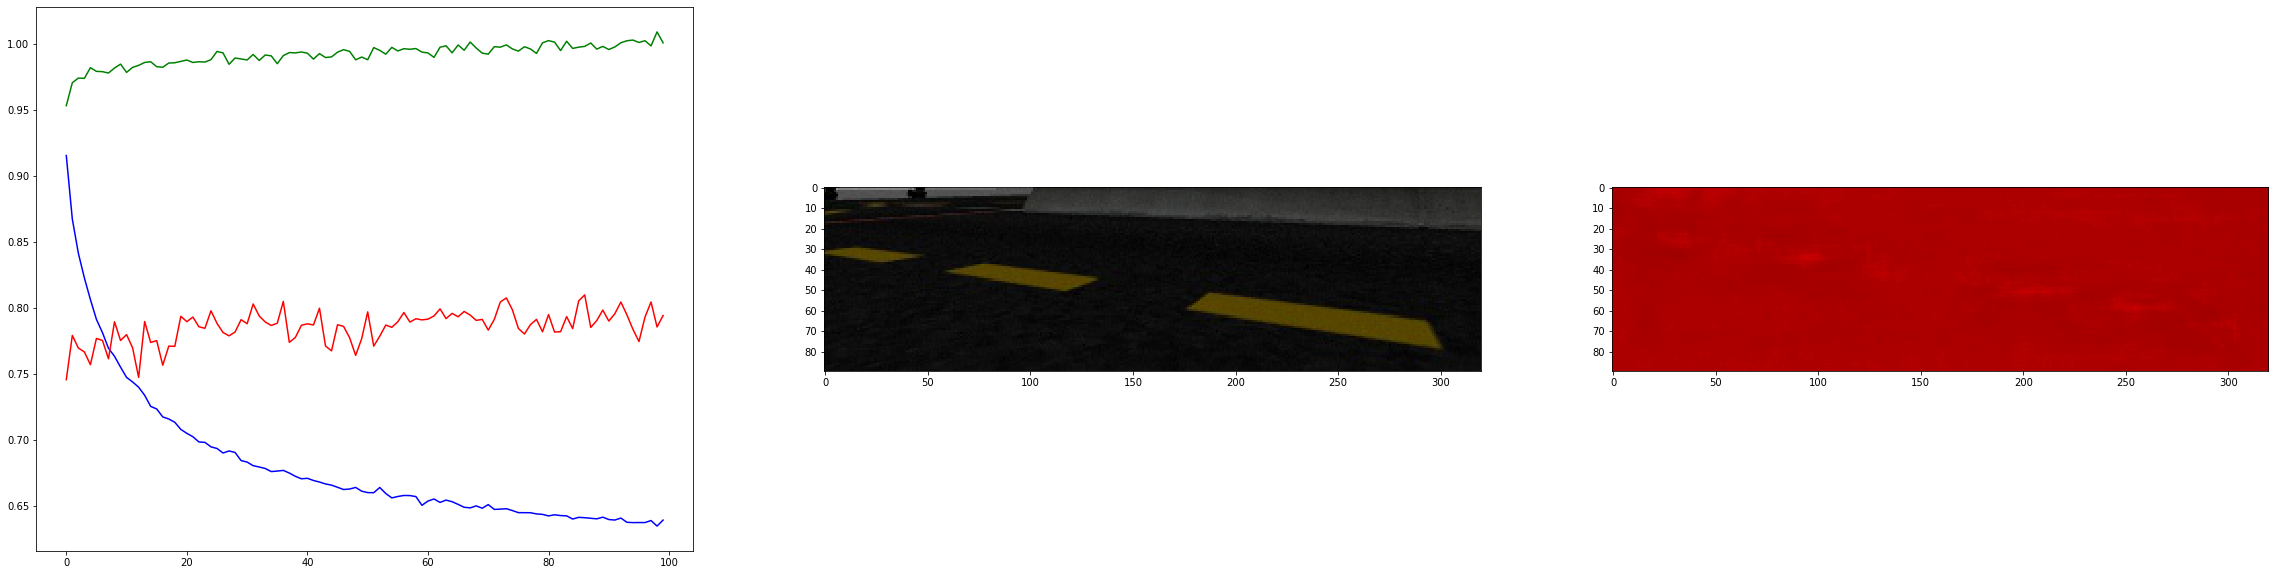

[0.9156683683395386, 0.8675785338878632, 0.8416876113414764, 0.8229857921600342, 0.8065842854976654, 0.7915890848636628, 0.7815229690074921, 0.7696741557121277, 0.7636112201213837, 0.7553825867176056, 0.7476037406921386, 0.7441861283779144, 0.7401939713954926, 0.734064700603485, 0.725649676322937, 0.723703373670578, 0.7176800894737244, 0.7161226058006287, 0.7136063992977142, 0.7082209944725036, 0.7052200961112977, 0.70267471909523, 0.6987211084365845, 0.6983783876895905, 0.6950063931941987, 0.6937783122062683, 0.6903349006175995, 0.6919001078605652, 0.6907357585430145, 0.6846025335788727, 0.6834700775146484, 0.6807242107391357, 0.6797405910491944, 0.678614797592163, 0.6762755012512207, 0.6766476690769195, 0.6771575152873993, 0.6751526927947998, 0.6726940870285034, 0.6708036530017852, 0.6711686861515045, 0.6695162642002106, 0.6683446228504181, 0.6668938517570495, 0.6659879457950592, 0.6643555688858033, 0.6626745283603668, 0.6630518996715545, 0.6642555141448975, 0.6614337635040283, 0.660

In [8]:
from IPython.display import clear_output

num_epochs = 100
train_steps_per_epoch = 50
test_steps_per_epoch = 10
batch_size = 16

collision_buffer = 35
path_length = 30

# For visualization 
focal_length = 190.68
baseline = 0.2
scale = 5

# Make Model
navnet = NavNet(input_shape=(3, 90, 320)).to(device)
optimizer = torch.optim.Adam(navnet.parameters(), lr=1e-4)

train_batch_gen = batch_generator(train_data, image_shape=(3,90,320), path_length=path_length, collision_buffering=collision_buffer, batch_size=batch_size)
test_normal_batch_gen = batch_generator(test_normal_data, image_shape=(3,90,320), path_length=path_length, collision_buffering=collision_buffer, batch_size=batch_size)
test_anormal_batch_gen = batch_generator(test_anormal_data, image_shape=(3,90,320), path_length=path_length, collision_buffering=collision_buffer, batch_size=batch_size)

train_loss = []
normal_test_loss = []
anormal_test_loss = []

for epoch in range(num_epochs):
        
    # Train
    avg_train_loss = 0
    navnet.train()
    for step in range(train_steps_per_epoch):
        optimizer.zero_grad()
        right_masks, right_images, left_masks, left_images = next(train_batch_gen)
        left_input = left_images
        output = navnet(left_input.to(device))
#         loss = navnet.loss(output*left_masks[:,:2,:,:].to(device), left_images.to(device)*left_masks.to(device), right_images.to(device)*right_masks.to(device))
        loss = navnet.loss(output.to(device), left_images.to(device), right_images.to(device))
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
        
    avg_train_loss /= train_steps_per_epoch
    train_loss.append(avg_train_loss)
    
    # Normal / Anormal testing
    
    # Normal
    navnet.eval()
    avg_normal_test_loss = 0
    display_output = None
    display_input = None
    for step in range(test_steps_per_epoch):
        right_masks, right_images, left_masks, left_images = next(test_normal_batch_gen)
        left_input = left_images
        output = navnet(left_input.to(device))
        loss = navnet.loss(output.to(device), left_images.to(device), right_images.to(device))
        avg_normal_test_loss += loss.item()
        
        # additional visualization ability
        display_output = output
        display_input = left_input
        
    avg_normal_test_loss /= test_steps_per_epoch
    normal_test_loss.append(avg_normal_test_loss)
    
    # Anormal
    avg_anormal_test_loss = 0
    navnet.eval()
    for step in range(test_steps_per_epoch):
        right_masks, right_images, left_masks, left_images = next(test_anormal_batch_gen)
        left_input = left_images
        output = navnet(left_input.to(device))
        loss = navnet.loss(output.to(device), left_images.to(device), right_images.to(device))
        avg_anormal_test_loss += loss.item()
        
    avg_anormal_test_loss /= test_steps_per_epoch
    anormal_test_loss.append(avg_anormal_test_loss)
    
    
    
    # Plot the losses in realtime
    clear_output(wait=True)
    
    fig = plt.figure(figsize=(40,10))
    fig.add_subplot(1,3,1)
    
    plt.plot(train_loss,  color='blue', label='train loss')
    plt.plot(normal_test_loss,  color='green', label='normal test loss')
    plt.plot(anormal_test_loss,  color='red', label='anormal test loss')

    fig.add_subplot(1,3,2)
    plt.imshow(utils.torch_image_to_cv_image(display_input[0]))
    
    fig.add_subplot(1,3,3)
    depth_map = focal_length*baseline/((display_output[0,0]*320).cpu().detach().numpy()) 
    depth_map = np.clip(depth_map, 0, scale)/scale
    depth_img = cv2.applyColorMap((depth_map*255).astype('uint8'), cv2.COLORMAP_JET);

    plt.imshow(depth_img)
    
    plt.show()
    
print(train_loss)
print("#########")
print(normal_test_loss)
print("#########")
print(anormal_test_loss)

### Visualize Model

In [9]:
def transform_img_with_disp(disp, right_image): 
    batch_size, _, height, width = right_image.size()

    # For applying disparities to images
    x_base = torch.linspace(-1, 1, width).repeat(batch_size, height, 1).type_as(disp) # shape  = Nxheightxwidth
    y_base = torch.linspace(-1, 1, height).repeat(batch_size, width, 1).transpose(1, 2).type_as(disp) 

    flow_feild = torch.stack((x_base+disp[:,0,:,:], y_base), dim=3)
    return F.grid_sample(right_image, flow_feild, align_corners=False)

In [11]:
import time, cv2
import numpy as np

patch_side_len = 32
threshold = 0.005
crop_line = 90

focal_length = 190.68
baseline = 0.2

navnet.eval()
dataset = test_normal_data
for i in range(1, len(dataset.data)):
    left_img = dataset.read_torch_image(i).unsqueeze(0).to(device)
    right_img = dataset.read_torch_image(i, right=True).unsqueeze(0).to(device)
    if len(left_img) > 0:
        cv_image = dataset.read_cv_image(i)

        model_output = navnet(left_img)
        
        transformed_left_image = transform_img_with_disp(model_output, right_img)
        np_transformed_img = utils.torch_image_to_cv_image(transformed_left_image[0].cpu().detach())

        heat_map = ((cv_image/255-np_transformed_img)**2)
#             ssim_left = torch.mean(self.SSIM(left_images, shifted_right_to_left)) 
#         loss_rl = alpha*ssim_left+(1-alpha)*left_l1_loss

        mask = np.sum(heat_map, axis=2)
        mask = (mask > threshold).astype(int)

        if loss > threshold:
            score = 1
        else:
            score = 0
            
        red = np.ones((cv_image.shape[0], cv_image.shape[1])) * mask
        green = np.ones((cv_image.shape[0], cv_image.shape[1])) * (1 - mask)
        color_mask = np.zeros(cv_image.shape)
        color_mask[:,:,0] = red
        color_mask[:,:,1] = green
        color_mask = (color_mask*255).astype('uint8')
        
        color_mask = cv2.medianBlur(color_mask,17)
        masked_image = cv2.addWeighted(cv_image,0.7,color_mask,0.3,0)  
        
        
        # Depth map
        depth_map = focal_length*baseline/((model_output[0,0]*320).cpu().detach().numpy())
        depth_map = np.clip(depth_map, 0, scale)/scale
        depth_img = cv2.applyColorMap((depth_map*255).astype('uint8'), cv2.COLORMAP_JET);        
        
        display_img = np.hstack((masked_image, (np_transformed_img*255).astype('uint8'), depth_img))
        
        cv2.imshow('image', cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        cv2.waitKey(50)

KeyboardInterrupt: 

### Save Model

In [12]:
# Standard pytorch model saving/loading
name = "navnet-v3"
torch.save(navnet.state_dict(), name + ".pt")
navnet.load_state_dict(torch.load(name + ".pt")) # test reloading model

<All keys matched successfully>